In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
import os
print("LD_LIBRARY_PATH:", os.environ.get('LD_LIBRARY_PATH'))


LD_LIBRARY_PATH: /usr/local/cuda/lib64:


In [3]:
import tensorflow as tf
print("GPUs detected:", tf.config.list_physical_devices('GPU'))


GPUs detected: []


In [4]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models #type: ignore
from tensorflow.keras.applications import ResNet50  #type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.optimizers.schedules import ExponentialDecay #type: ignore
from tensorflow.keras.regularizers import l2 #type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
from tensorflow.keras.metrics import AUC, Precision, Recall #type: ignore

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class ImageDataset:
    def __init__(self, data_dir, max_images_per_class=1500):
        self.data_dir = data_dir
        self.max_images_per_class = max_images_per_class  
        self.images = []
        self.labels = []
        self.class_names = ['hojas', 'otros', 'animales'] 
        
    def load_data(self):
        """Carga datos con validación mejorada y límite de imágenes"""
        total_images = 0
        class_counts = {}
        
        for idx, label in enumerate(self.class_names):
            label_dir = os.path.join(self.data_dir, label)
            if not os.path.exists(label_dir):
                print(f"Advertencia: no existe la carpeta {label_dir}")
                continue
                
            class_count = 0
            for image_name in os.listdir(label_dir):
                if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    continue
                    
                img_path = os.path.join(label_dir, image_name)
                img_array = self.load_and_preprocess_image(img_path)
                if img_array is not None:
                    self.images.append(img_array)
                    self.labels.append(idx) 
                    class_count += 1
                    total_images += 1

                if class_count >= self.max_images_per_class:
                    print(f"Clase '{label}': Se han cargado el máximo de {self.max_images_per_class} imágenes.")
                    break
            
            class_counts[label] = class_count
            print(f"Clase '{label}': {class_count} imágenes")
        
        print(f"Total de imágenes cargadas: {total_images}")
        
        # Verificar balance de clases
        if class_counts:
            max_count = max(class_counts.values())
            min_count = min(class_counts.values())
            ratio = max_count / min_count if min_count > 0 else float('inf')
            
            if ratio > 3:
                print(f"Desbalance detectado: ratio {ratio:.2f}:1")
                print("Considera usar class_weight o data augmentation")
        
        return class_counts

    def load_and_preprocess_image(self, img_path):
        """Carga y preprocesa imagen con manejo de errores mejorado"""
        try:
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Error al cargar {img_path}: {e}")
            return None


In [7]:
print("Clasificador de Hojas")
print("=" * 50)

data_dir = 'data/'
dataset = ImageDataset(data_dir)
class_counts = dataset.load_data()

if not dataset.images:
    print("No se cargaron imágenes. Verifica la estructura de carpetas.")
    exit(1)

Clasificador de Hojas
Clase 'hojas': Se han cargado el máximo de 1500 imágenes.
Clase 'hojas': 1500 imágenes
Clase 'otros': Se han cargado el máximo de 1500 imágenes.
Clase 'otros': 1500 imágenes
Clase 'animales': Se han cargado el máximo de 1500 imágenes.
Clase 'animales': 1500 imágenes
Total de imágenes cargadas: 4500


In [8]:
images = np.array(dataset.images)
labels = np.array(dataset.labels)
labels_cat = to_categorical(labels, num_classes=3)

print(f"\nDatos preparados:")
print(f"Imágenes: {images.shape}")
print(f"Etiquetas: {labels_cat.shape}")


Datos preparados:
Imágenes: (4500, 224, 224, 3)
Etiquetas: (4500, 3)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(
        images, labels_cat, 
        test_size=0.2, 
        random_state=42, 
        stratify=labels
    )

print(f"\nDivisión de datos:")
print(f"Entrenamiento: {X_train.shape[0]} imágenes")
print(f"Validación: {X_val.shape[0]} imágenes")


División de datos:
Entrenamiento: 3600 imágenes
Validación: 900 imágenes


In [10]:
# Importaciones necesarias
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, TensorBoard
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import (
    Precision, Recall, AUC, F1Score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

In [ ]:
def modelo_base():
    """
    Crea y configura el modelo convolucional para clasificación de hojas.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (112, 112, 32)
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (56, 56, 64)
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (28, 28, 128)
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)), # Sale (14, 14, 256)
        

        Flatten(), 
        Dense(256, activation='relu'), 
        BatchNormalization(),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1.5e-5),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            Precision(),
            Recall(),
            AUC()
        ]
    )
    
    return model

modelo = modelo_base()

/home/juan0/Backend-Tesis/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749522908.019343  149973 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
def configurar_callbacks():
    """
    Configura los callbacks para el entrenamiento.
    """
    callbacks = [
        EarlyStopping(
            patience=3,
            min_delta=0.001,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            filepath='mejor_modelo.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
    
    return callbacks

callbacks = configurar_callbacks()

In [13]:
def entrenar_modelo_con_dataset(modelo, X_train, y_train, X_val, y_val, callbacks, batch_size, epochs):
    """
    Entrena el modelo usando los pipelines de tf.data.
    """
    history = modelo.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1
    )
    return history


In [14]:
history = entrenar_modelo_con_dataset(
    modelo, 
    X_train, y_train, X_val, y_val,
    callbacks, 
    batch_size=16,
    epochs=20
)

Epoch 1/20


I0000 00:00:1749522913.729606  150104 service.cc:152] XLA service 0x7a524c005650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749522913.729661  150104 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-09 21:35:13.796017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749522914.132358  150104 cuda_dnn.cc:529] Loaded cuDNN version 91001


  2/225 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.3750 - auc: 0.5361 - loss: 1.5578 - precision: 0.3510 - recall: 0.3125

I0000 00:00:1749522919.823716  150104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6763 - auc: 0.8431 - loss: 0.8795 - precision: 0.6913 - recall: 0.6571

225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.6765 - auc: 0.8433 - loss: 0.8789 - precision: 0.6915 - recall: 0.6573 - val_accuracy: 0.3333 - val_auc: 0.5978 - val_loss: 1.8265 - val_precision: 0.3352 - val_recall: 0.3333 - learning_rate: 1.5000e-05
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8353 - auc: 0.9566 - loss: 0.4066 - precision: 0.8475 - recall: 0.8280

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8353 - auc: 0.9566 - loss: 0.4065 - precision: 0.8475 - recall: 0.8280 - val_accuracy: 0.7156 - val_auc: 0.8801 - val_loss: 0.6886 - val_precision: 0.7357 - val_recall: 0.6711 - learning_rate: 1.5000e-05
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9049 - auc: 0.9826 - loss: 0.2466 - precision: 0.9131 - recall: 0.8956

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9049 - auc: 0.9826 - loss: 0.2466 - precision: 0.9131 - recall: 0.8956 - val_accuracy: 0.8433 - val_auc: 0.9562 - val_loss: 0.4029 - val_precision: 0.8567 - val_recall: 0.8300 - learning_rate: 1.5000e-05
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9358 - auc: 0.9922 - loss: 0.1709 - precision: 0.9402 - recall: 0.9290

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9358 - auc: 0.9922 - loss: 0.1709 - precision: 0.9402 - recall: 0.9290 - val_accuracy: 0.8711 - val_auc: 0.9685 - val_loss: 0.3475 - val_precision: 0.8784 - val_recall: 0.8667 - learning_rate: 1.5000e-05
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9606 - auc: 0.9957 - loss: 0.1244 - precision: 0.9620 - recall: 0.9587 - val_accuracy: 0.8700 - val_auc: 0.9685 - val_loss: 0.3493 - val_precision: 0.8810 - val_recall: 0.8633 - learning_rate: 1.5000e-05
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9499 - auc: 0.9957 - loss: 0.1278 - precision: 0.9531 - recall: 0.9480

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9499 - auc: 0.9957 - loss: 0.1278 - precision: 0.9531 - recall: 0.9480 - val_accuracy: 0.8833 - val_auc: 0.9691 - val_loss: 0.3423 - val_precision: 0.8870 - val_recall: 0.8811 - learning_rate: 1.5000e-05
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9793 - auc: 0.9989 - loss: 0.0726 - precision: 0.9807 - recall: 0.9790

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9793 - auc: 0.9989 - loss: 0.0726 - precision: 0.9807 - recall: 0.9790 - val_accuracy: 0.8911 - val_auc: 0.9747 - val_loss: 0.3039 - val_precision: 0.8967 - val_recall: 0.8878 - learning_rate: 1.5000e-05
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9758 - auc: 0.9986 - loss: 0.0728 - precision: 0.9772 - recall: 0.9728 - val_accuracy: 0.8856 - val_auc: 0.9739 - val_loss: 0.3201 - val_precision: 0.8879 - val_recall: 0.8800 - learning_rate: 1.5000e-05
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9861 - auc: 0.9996 - loss: 0.0471 - precision: 0.9885 - recall: 0.9847 - val_accuracy: 0.8833 - val_auc: 0.9759 - val_loss: 0.3105 - val_precision: 0.8891 - val_recall: 0.8822 - learning_rate: 1.5000e-05
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9834 - auc: 0.9993 - loss: 0.0530 - precision: 0.9841 - recall: 0.9831 - val_accuracy: 0.8867 - val_auc: 0.9738 - val_loss: 0.3347

In [ ]:
def evaluar_modelo(modelo, X_val, y_val):
    """
    Evalúa el modelo con métricas detalladas.
    """
    y_pred = modelo.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = np.argmax(y_val, axis=1)
    
    metrics = {}
    for i in range(3):
        y_pred_i = (y_pred_class == i)
        y_true_i = (y_true_class == i)
        
        metrics[f'clase_{i}'] = {
            'precision': precision_score(y_true_i, y_pred_i),
            'recall': recall_score(y_true_i, y_pred_i),
            'f1': f1_score(y_true_i, y_pred_i),
            'auc': roc_auc_score(y_true_i, y_pred_i)
        }
    
    metrics['general'] = {
        'accuracy': accuracy_score(y_true_class, y_pred_class),
        'macro_f1': f1_score(y_true_class, y_pred_class, average='macro'),
        'macro_precision': precision_score(y_true_class, y_pred_class, average='macro'),
        'macro_recall': recall_score(y_true_class, y_pred_class, average='macro')
    }
    
    return metrics

metrics = evaluar_modelo(modelo, X_val, y_val)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


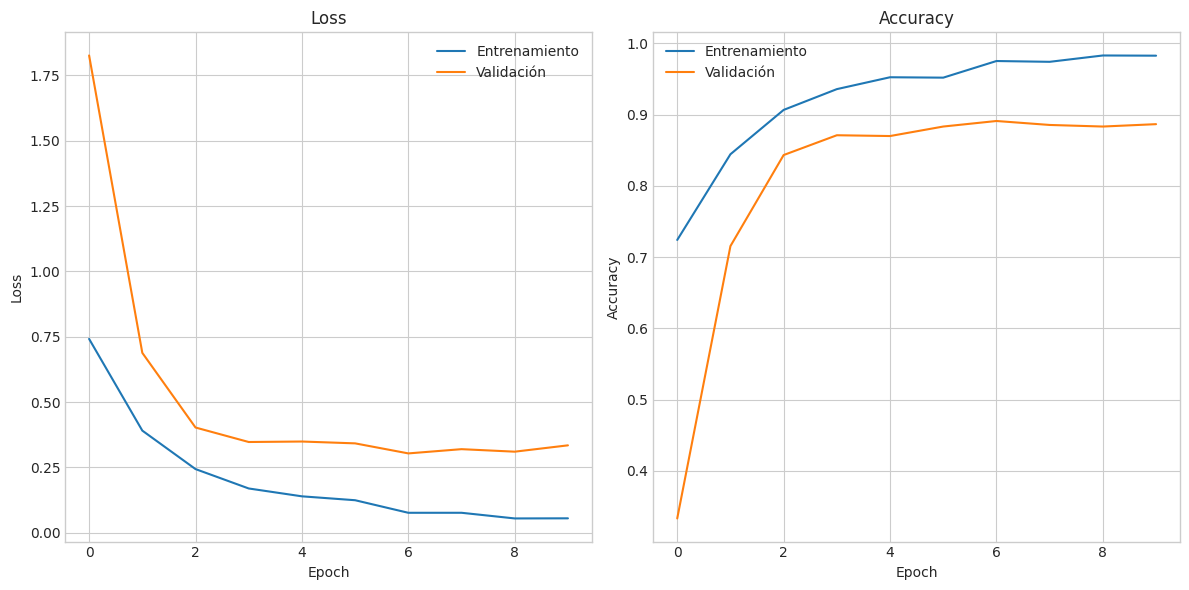

In [ ]:

def visualizar_resultados(history):
    """
    Visualiza las métricas de entrenamiento.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [12, 6]
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualizar_resultados(history)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


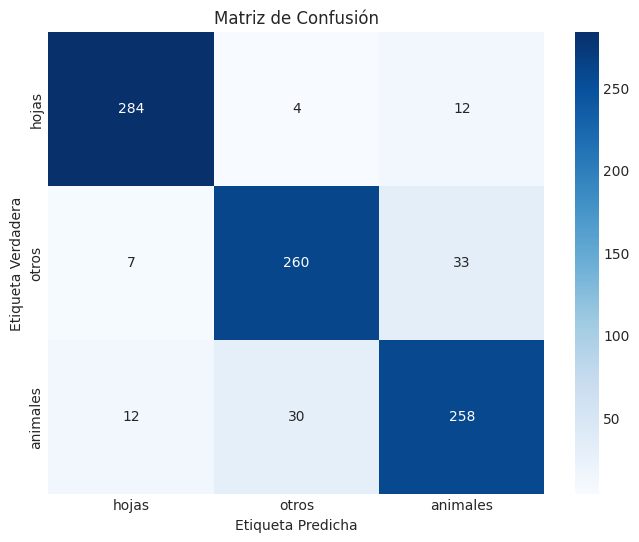

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = modelo.predict(X_val)


y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

class_names = ['hojas', 'otros', 'animales']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


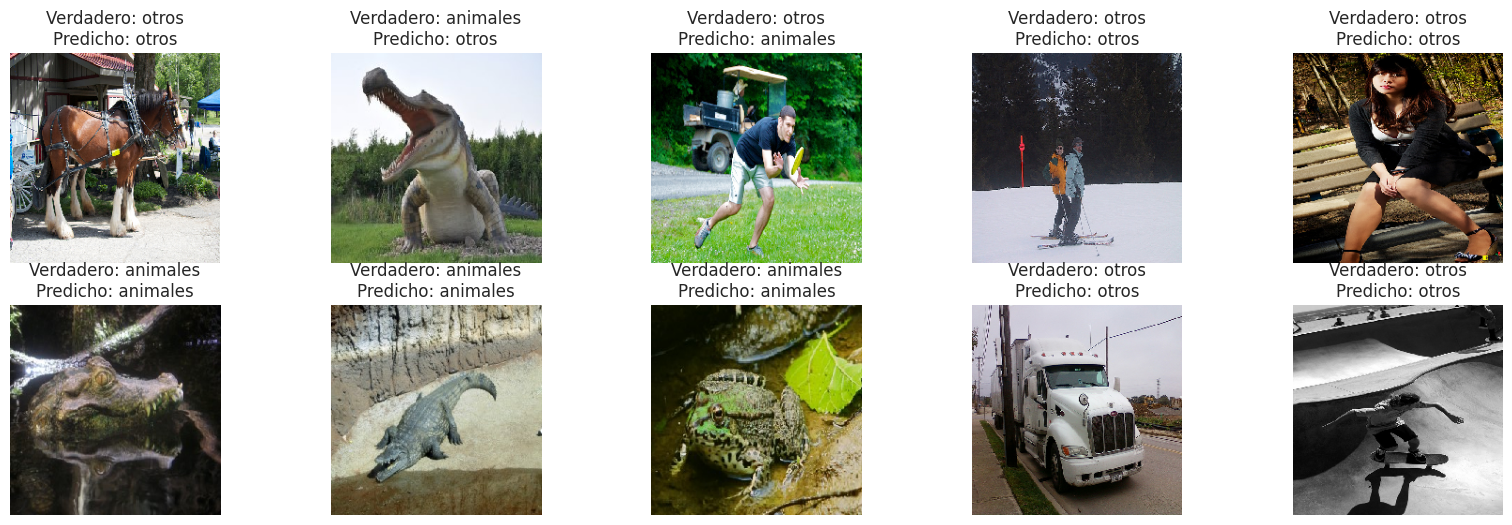

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

indices = random.sample(range(len(X_val)), 10)
class_names = ['hojas', 'otros', 'animales']
plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_val[idx]
    true_label = np.argmax(y_val[idx])
    
    # Expandir dims para predecir (batch=1)
    img_input = np.expand_dims(img, axis=0)
    pred_probs = modelo.predict(img_input)
    pred_label = np.argmax(pred_probs[0])
    
    # Mostrar imagen
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Verdadero: {class_names[true_label]}\nPredicho: {class_names[pred_label]}")
    
plt.show()




In [31]:
modelo.save("modelo_hojas_multiclasev3.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


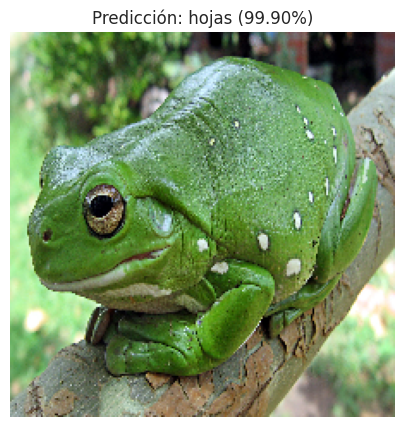

Shape de la imagen procesada: (224, 224, 3)
Predicción cruda (probabilidades): [9.9900144e-01 4.9301510e-04 5.0552527e-04]
Predicción final: hojas con probabilidad 0.9990


In [ ]:
from tensorflow.keras.models import load_model #type: ignore
from tensorflow.keras.preprocessing import image #type: ignore

modelo_cargado = load_model('modelo_hojas_multiclasev3.h5')

img_path = 'tests/frog.jpg'
clases = ['hojas', 'otros', 'animales']

img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

prediccion = modelo_cargado.predict(img_array_expanded)

indice_clase = np.argmax(prediccion[0])
etiqueta_predicha = clases[indice_clase]
probabilidad = prediccion[0][indice_clase]

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicción: {etiqueta_predicha} ({probabilidad:.2%})")
plt.show()

print(f"Shape de la imagen procesada: {img_array.shape}")
print(f"Predicción cruda (probabilidades): {prediccion[0]}")
print(f"Predicción final: {etiqueta_predicha} con probabilidad {probabilidad:.4f}")